## Excercise 3

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Task 1.1:

# Download the ImageNet class index file
import urllib.request
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
class_names = urllib.request.urlopen(LABELS_URL).read().decode('utf-8').splitlines()

# Load pretrained ResNet-50
# https://pytorch.org/hub/pytorch_vision_resnet/
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='DEFAULT')
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model.eval()

# Print the layers of ResNet-50
for name, layer in model.named_children():
    print(f"{name}: {layer}")
##-----------------Your code above-----------------##

Using cache found in /export/home/pima/.cache/torch/hub/pytorch_vision_v0.10.0


conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu: ReLU(inplace=True)
maxpool: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

In [3]:
# Task 1.2 and 1.3:


##-----------------Your code here-----------------##
# Register hooks to the final conv layer
def save_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activation(module, input, output):
    activations.append(output)

# Hook into the last conv block of ResNet-18
final_conv = model.layer4[-1]
final_conv.register_forward_hook(save_activation)
final_conv.register_backward_hook(save_gradient)
##-----------------Your code above-----------------##

gradients = []
activations = []

In [4]:
# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
img_path = 'input/Chihuahua.jpg'  # Replace with your image path
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)

In [5]:
# Task 1.4-1

def calculate_grad_cam(gradients, activations):
    """
    Calculate the Grad-CAM heatmap.
    """

    ##-----------------Your code here-----------------##
    grads_val = gradients[0].squeeze(0).detach().numpy()     # [C, H, W]
    acts_val = activations[0].squeeze(0).detach().numpy()    # [C, H, W]

    print("grads_val.shape", grads_val.shape)
    
    # averages across height and width dimensions. This produces importance weights for each channel
    weights = grads_val.mean(axis=(1, 2))                    # average pooling over spatial

    # Creates empty heatmap array
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)     # [H, W]
    
    # Iterates through each channel, multiplying channel's activation by its weight
    # Accumulates weighted activations to form final heatmap
    for i, w in enumerate(weights):
        cam += w * acts_val[i]

    # Post-Processing of the heatmap: 
    # Keeps only positive contributions
    # Resizing to 224×224: Makes heatmap match input image size
    # Min-max normalization.
    # Subtracts minimum value
    # Divides by maximum value
    # Results in values between 0 and 1

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224)) # this is important, as the activations are not the same size as the input image
    cam -= cam.min()
    cam /= cam.max() + 1e-8  # Avoid division by zero
    return cam
    ##-----------------Your code above-----------------##


def extract_bounding_boxes(cam, img, threshold=0.3):
    """
    Extract bounding boxes from the Grad-CAM heatmap and draw them on the image.
    You can adjust the threshold to control the sensitivity of the bounding box extraction.
    The higher the threshold, the fewer boxes will be detected.
    """
    # Convert the Grad-CAM heatmap to an 8-bit image
    heatmap = (cam * 255).astype(np.uint8)
    # Apply a binary threshold to the heatmap to isolate the most salient regions
    _, binary_map = cv2.threshold(heatmap, threshold * 255, 255, cv2.THRESH_BINARY)

    # Find contours in the binary map to detect connected regions
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Resize the original image to match the Grad-CAM heatmap size (224x224)
    img_np = np.array(img.resize((224, 224)))

    # Collect bounding boxes
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x + w, y + h])  # [x1, y1, x2, y2]

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_np, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img_np


Predicted class: 151 - Chihuahua
grads_val.shape (2048, 7, 7)


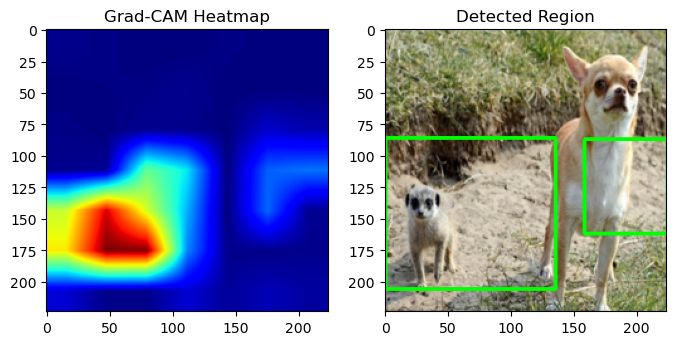

In [ ]:
# Task 1.4-2

# Forward pass
output = model(input_tensor)
# id of the predicted class
pred_class = output.argmax().item()

print(f"Predicted class: {pred_class} - {class_names[pred_class]}")

# Backward pass to get gradients for the predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
cam = calculate_grad_cam(gradients, activations)

# Extract bounding boxes
bounding_box = extract_bounding_boxes(cam, img)

# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 2, 2)
plt.imshow(bounding_box)
plt.title("Detected Region")
plt.show()

Predicted class: 151 - Chihuahua
Predicted class: 299 - meerkat
Predicted class: 298 - mongoose
Predicted class: 262 - Brabancon griffon
Predicted class: 182 - Border terrier
Predicted class: 299 - meerkat
grads_val.shape (2048, 7, 7)


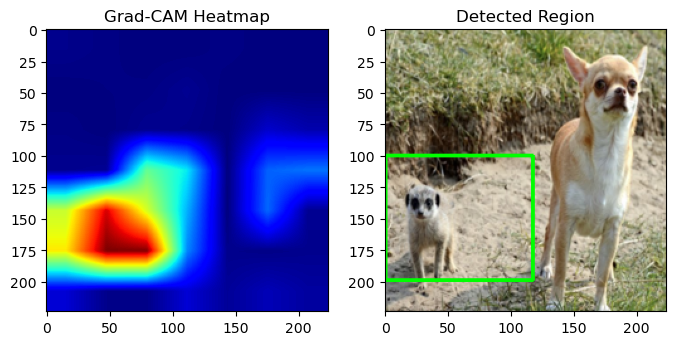

In [7]:
# task 1.5


##-----------------Your code here-----------------##
gradients.clear()
activations.clear()

# Forward pass
output = model(input_tensor)
# id of the predicted class
top5_classes = output.argsort(descending=True)[0, :5].tolist()

for idx in range(5):
    print(f"Predicted class: {top5_classes[idx]} - {class_names[top5_classes[idx]]}")

# pick a class to visualize
pred_class = 299

print(f"Predicted class: {pred_class} - {class_names[pred_class]}")

# Backward pass to get gradients for the predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Grad-CAM calculation
cam = calculate_grad_cam(gradients, activations)

# Extract bounding boxes
bounding_box = extract_bounding_boxes(cam, img, threshold=0.3)

# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 2, 2)
plt.imshow(bounding_box)
plt.title("Detected Region")
plt.show()

##-----------------Your code above-----------------##



=== Top-1: Chihuahua ===
grads_val.shape (2048, 7, 7)


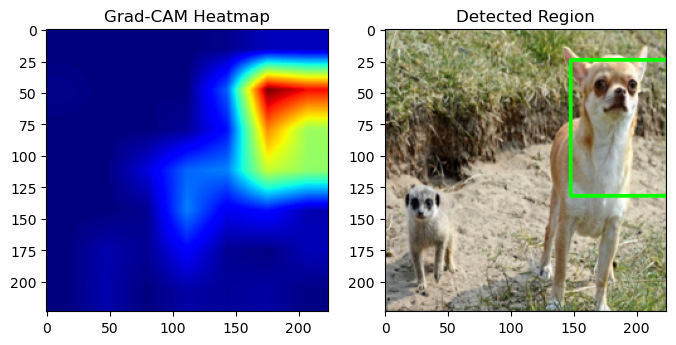


=== Top-2: meerkat ===
grads_val.shape (2048, 7, 7)


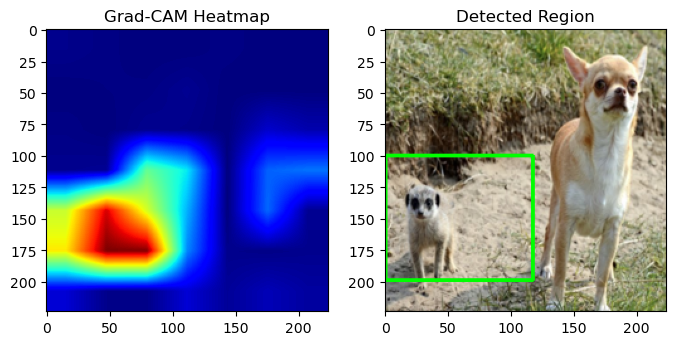


=== Top-3: mongoose ===
grads_val.shape (2048, 7, 7)


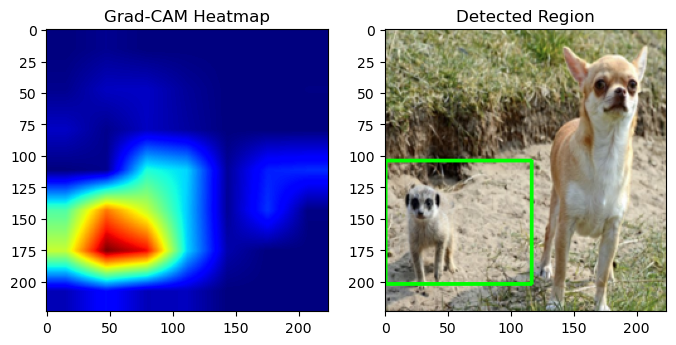


=== Top-4: Brabancon griffon ===
grads_val.shape (2048, 7, 7)


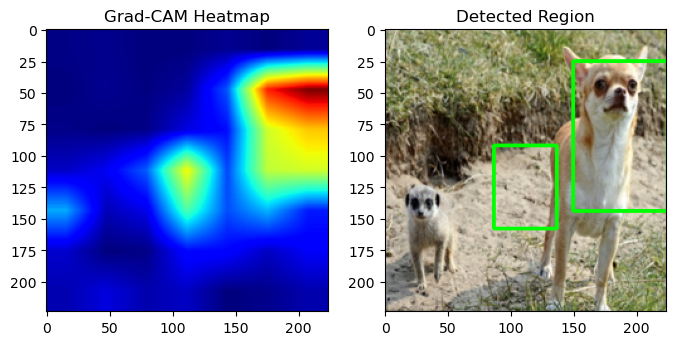


=== Top-5: Border terrier ===
grads_val.shape (2048, 7, 7)


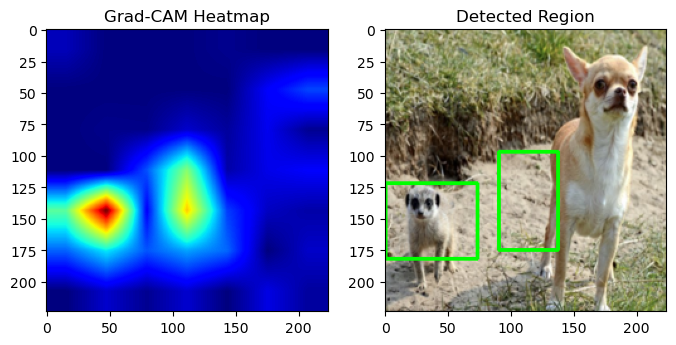

In [9]:
topk = 5

for k in range(topk):
    # Clear hooks' outputs
    gradients.clear()
    activations.clear()

    pred_class = top5_classes[k]
    print(f"\n=== Top-{k+1}: {class_names[pred_class]} ===")

    # Forward pass again to trigger hooks
    output = model(input_tensor)

    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()

    # Grad-CAM calculation
    cam = calculate_grad_cam(gradients, activations)

    # Extract bounding boxes
    bounding_box = extract_bounding_boxes(cam, img)

    # Show result
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 2, 2)
    plt.imshow(bounding_box)
    plt.title("Detected Region")
    plt.show()

### Task 2. 

In [11]:
# Task 2.1
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='DEFAULT')
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model.eval()

final_conv = model.layer4[-1]

# Task 2.2
activations = []

def save_activation(module, input, output):
    # from task 1
    activations.append(output)

# Hook into the last conv block of ResNet-18
final_conv = model.layer4[-1]
final_conv.register_forward_hook(save_activation)


# === Load and preprocess image ===
img_path = 'input/Bulldog.png'  # Replace with your image path
img = Image.open(img_path).convert('RGB')        # Ensure RGB format
input_tensor = preprocess(img).unsqueeze(0)      # Apply transforms and add batch dimension

# === Hook to extract last conv-layer activations (for CAM) ===
activations.clear()  # Clear previous values if running in a loop
final_conv.register_forward_hook(save_activation)  # Register forward hook to capture feature maps

Using cache found in /export/home/pima/.cache/torch/hub/pytorch_vision_v0.10.0


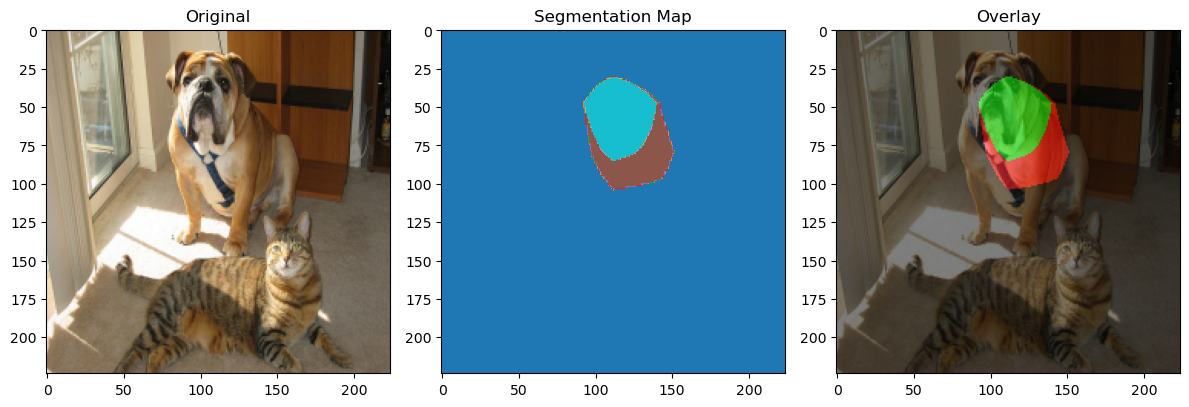

In [ ]:
# Task 2.3

# === Forward pass through the model ===
with torch.no_grad():
    output = model(input_tensor)  # Forward pass without gradients

# === Select top-k predicted classes ===
topk = 2
top_classes = output[0].topk(topk).indices.tolist()  # Get top 3 predicted class indices

# === Extract the activation map and classifier weights ===
feature_map = activations[0].squeeze(0)        # Shape: [2048, 7, 7]; last conv-layer features
# this is important
fc_weights = model.fc.weight.data              # Shape: [1000, 2048]; linear classifier weights


# === Prepare empty masks ===
segmentation = np.zeros((224, 224), dtype=np.uint8)      # Final segmentation labels per pixel
overlay = np.zeros((224, 224, 3), dtype=np.uint8)        # RGB overlay for visualization

# === Assign a color to each of the top-3 classes ===
class_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]    # Colors (BGR format for OpenCV)

# === Loop over top-3 classes to generate class-specific CAMs and segmentations ===
for i, cls in enumerate(top_classes):
    weights = fc_weights[cls]                              # Get weights for this class (shape: [2048])
    
    # Compute CAM via weighted sum over feature map channels
    cam = torch.einsum('c,chw->hw', weights, feature_map)  # Shape: [7, 7]
    cam = cam.cpu().numpy()

    # Normalize CAM to [0, 1]
    cam = np.maximum(cam, 0)       # ReLU
    cam -= cam.min()
    cam /= cam.max() + 1e-8        # Prevent divide by zero

    # Task 2.4

    # Resize CAM to match original input resolution (224x224)
    cam = cv2.resize(cam, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Threshold CAM to get binary segmentation mask for this class
    mask = cam > 0.5  # Adjust this value for different sensitivity levels

    # Update segmentation map (assign unique label for each class)
    segmentation[mask] = i + 1     # 1, 2, 3 corresponding to top-3 classes

    # Update overlay image with corresponding class color
    for c in range(topk):             # Loop over RGB channels
        overlay[..., c][mask] = class_colors[i][c]


# Task 2.5
# === Assign black color to background (pixels not covered by any top class) ===
bg_mask = segmentation == 0
overlay[bg_mask] = (0, 0, 0)  # Background in black

# === Blend original image with segmentation overlay for visualization ===
original_img = np.array(img.resize((224, 224)))  # Resize to match overlay
blended = cv2.addWeighted(original_img, 0.5, overlay, 0.5, 0)  # Semi-transparent overlay

# === Show the results ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(segmentation, cmap='tab10')
plt.title('Segmentation Map')

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title('Overlay')

plt.tight_layout()
plt.show()